In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Leemos los datos del fichero csv
file_path="COVID_CV_Ministerio.csv"
data=pd.read_csv(file_path,converters={"fecha":pd.to_datetime})

# Cambiamos el formato de la columna UCI a float y de la fecha a dateframe
data["UCI"] = pd.to_numeric(data.UCI, errors='coerce')
data['fecha'] = pd.to_datetime(data["fecha"].dt.strftime('%d-%m-%Y'))

# Calculamos los datos diarios como la diferencia de los totales
data['casos_24h']=data["casos_tot"].diff()
data['fallecidos_24h']=data["fallecidos_tot"].diff()

# Ponemos la fecha como indice, añadimos los días que faltan y volvemos a quitar la fecha como indice
data=data.set_index("fecha")
data=data.resample("D").asfreq()
data=data.reset_index()

# data.tail(10)


# print(data.dtypes)

In [3]:
# Calculamos la indicencia a 14 dias

IA_14d=[None]*13

for i in data.index[13:]:
    if (not np.isnan(data["casos_24h"].iloc[i])):
        IA_14d.append("{:.2f}".format(data["casos_24h"].iloc[i+1-14:i+1].sum()*1e5/5057353))
    else:
        IA_14d.append(None)

IA_14d=np.array(IA_14d,dtype=float)

data["IA_14d_me"]=IA_14d

# data.tail(5)

In [4]:
# Calculamos la indicencia a 7 dias

IA_7d=[None]*6

for i in data.index[6:]:
    if (not np.isnan(data["casos_24h"].iloc[i])):
#         IA_7d.append("{:.2f}".format(data["casos_24h"].iloc[i+1-7:i+1].sum()*1e5/4.975e6))
        IA_7d.append("{:.2f}".format(data["casos_24h"].iloc[i+1-7:i+1].sum()*1e5/5057353))
    else:
        IA_7d.append(None)

IA_7d=np.array(IA_7d,dtype=float)

data["IA_7d_me"]=IA_7d

data=data.set_index("fecha")

data[["UCI","hospitalizados"]].to_csv(path_or_buf="hosp_UCI.csv")

# data.tail(5)

In [5]:
# Copiamos la tabla en una nueva para eliminar las filas que no tiene datos para el ajuste
temp2=data.copy()
temp2.drop("casos_24h_GVA",axis=1,inplace=True)
temp2.drop("por_hosp",axis=1,inplace=True)
temp2.drop("por_UCI",axis=1,inplace=True)
temp2.drop("UCI",axis=1,inplace=True)
temp2.drop("hospitalizados",axis=1,inplace=True)
temp2=temp2.dropna(how='any',axis=0)

temp3=data.copy()
temp3.drop("casos_24h_GVA",axis=1,inplace=True)
temp3.drop("por_hosp",axis=1,inplace=True)
temp3.drop("por_UCI",axis=1,inplace=True)
temp3=temp3.dropna(how='any',axis=0)


In [6]:
# Creamos tablas con una submuestra de la tabla original para luego representar

# Datos 2021
data_2021=data.copy()
data_2021=data["2021-03-01":]

# Datos de hospitalización y UCI
data_hosp=data.copy()
data_hops=data["2020-08-20":]

In [7]:
# Parámetros que vamos a usar para crear la caja donde vamos a poner texto en la figura
bbox_args = dict(boxstyle="round", fc="0.8")

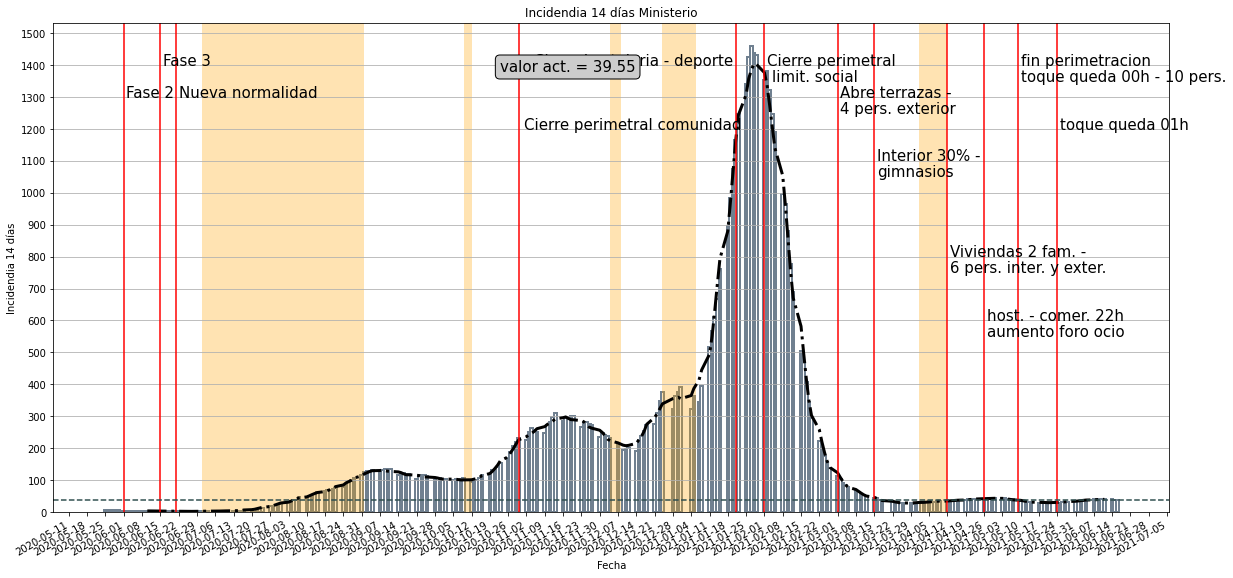

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
graf1=ax.bar(data.index,data["inci_14"],width=1,fill=False,linewidth=2,ec="slategray")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp2["inci_14"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linestyle="-.",linewidth=3)

# Dibujamos líneas verticales con cada cambio de las restricciones
ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
ax.text("2020-06-02",1300,"Fase 2",fontsize=15)

ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
ax.text("2020-06-16",1400,"Fase 3",fontsize=15)

ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
ax.text("2020-06-22",1300,"Nueva normalidad",fontsize=15)

ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
ax.text("2020-11-01",1200,"Cierre perimetral comunidad",fontsize=15)

ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
ax.text("2021-01-20",1400,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
ax.text("2021-02-02",1400,"Cierre perimetral",fontsize=15)
ax.text("2021-02-04",1350,"limit. social",fontsize=15)

ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
ax.text("2021-03-02",1300,"Abre terrazas -",fontsize=15)
ax.text("2021-03-02",1250,"4 pers. exterior",fontsize=15)

ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
ax.text("2021-03-16",1100,"Interior 30% -",fontsize=15)
ax.text("2021-03-16",1050,"gimnasios",fontsize=15)

ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
ax.text("2021-04-13",800,"Viviendas 2 fam. -",fontsize=15)
ax.text("2021-04-13",750,"6 pers. inter. y exter.",fontsize=15)

ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
ax.text("2021-04-27",600,"host. - comer. 22h",fontsize=15)
ax.text("2021-04-27",550,"aumento foro ocio",fontsize=15)

ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
ax.text("2021-05-10",1400,"fin perimetracion",fontsize=15)
ax.text("2021-05-10",1350,"toque queda 00h - 10 pers.",fontsize=15)

ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
ax.text("2021-05-25",1200,"toque queda 01h",fontsize=15)

ax.axhline(y=data["inci_14"].iloc[-1],color="darkslategray",linestyle="--")

ax.annotate("valor act. = {:.5}".format(data["inci_14"].iloc[-1])
                  ,xy=(0.4, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 14 días Ministerio')
ax.set_ylabel('Incidendia 14 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 100))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

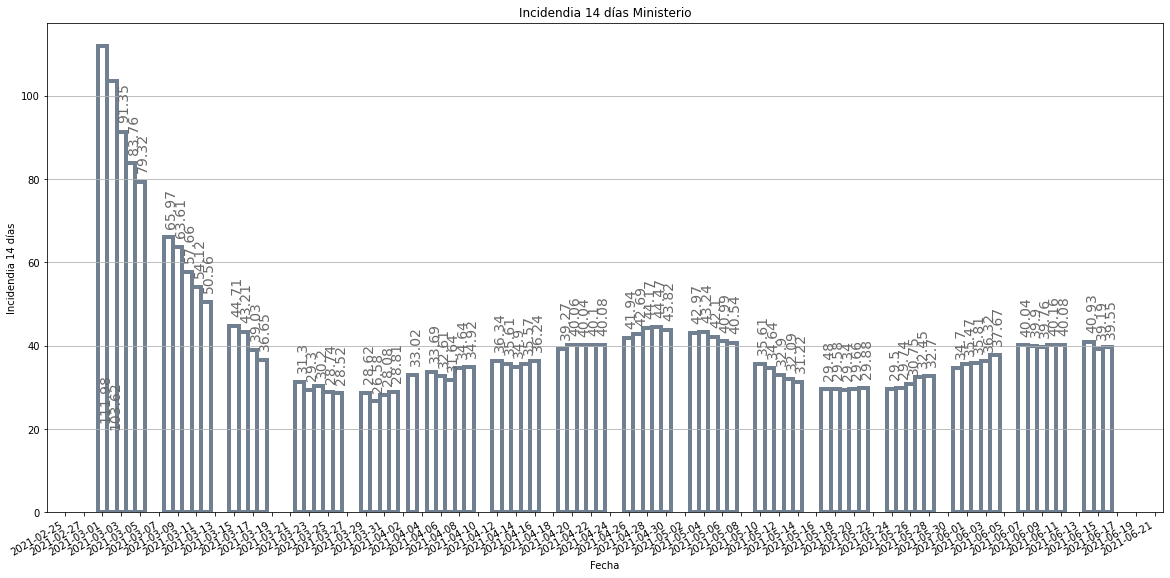

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data_2021.index,data_2021["inci_14"],width=1,fill=False,linewidth=4,ec="slategray")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 14 días Ministerio')
ax.set_ylabel('Incidendia 14 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 20))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 100:
        ax.text(i.get_x()+.1, i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 100:
            ax.text(i.get_x()+.1, i.get_height()+3, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

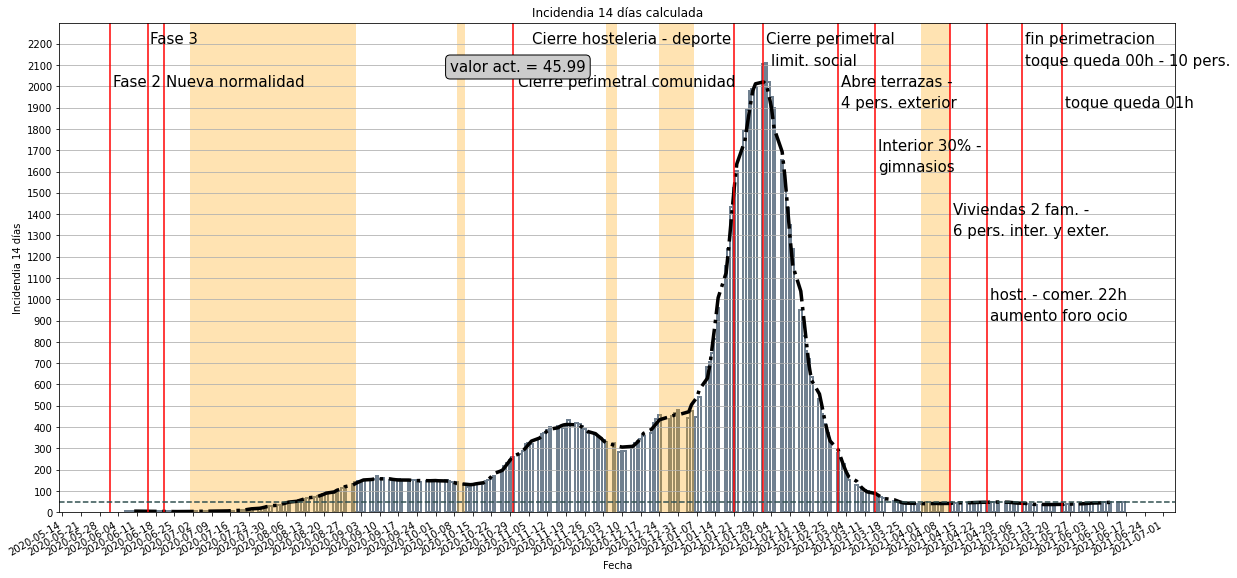

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
graf1=ax.bar(data.index,data["IA_14d_me"],width=1,fill=False,linewidth=2,ec="slategray")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp2["IA_14d_me"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linestyle="-.",linewidth=3.5)

# Dibujamos líneas verticales con cada cambio de las restricciones
ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
ax.text("2020-06-02",2000,"Fase 2",fontsize=15)

ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
ax.text("2020-06-16",2200,"Fase 3",fontsize=15)

ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
ax.text("2020-06-22",2000,"Nueva normalidad",fontsize=15)

ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
ax.text("2020-11-01",2000,"Cierre perimetral comunidad",fontsize=15)

ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
ax.text("2021-01-20",2200,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
ax.text("2021-02-02",2200,"Cierre perimetral",fontsize=15)
ax.text("2021-02-04",2100,"limit. social",fontsize=15)

ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
ax.text("2021-03-02",2000,"Abre terrazas -",fontsize=15)
ax.text("2021-03-02",1900,"4 pers. exterior",fontsize=15)

ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
ax.text("2021-03-16",1700,"Interior 30% -",fontsize=15)
ax.text("2021-03-16",1600,"gimnasios",fontsize=15)

ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
ax.text("2021-04-13",1400,"Viviendas 2 fam. -",fontsize=15)
ax.text("2021-04-13",1300,"6 pers. inter. y exter.",fontsize=15)

ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
ax.text("2021-04-27",1000,"host. - comer. 22h",fontsize=15)
ax.text("2021-04-27",900,"aumento foro ocio",fontsize=15)

ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
ax.text("2021-05-10",2200,"fin perimetracion",fontsize=15)
ax.text("2021-05-10",2100,"toque queda 00h - 10 pers.",fontsize=15)

ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
ax.text("2021-05-25",1900,"toque queda 01h",fontsize=15)

ax.axhline(y=data["IA_14d_me"].iloc[-1],color="darkslategray",linestyle="--")

ax.annotate("valor act. = {:.5}".format(data["IA_14d_me"].iloc[-1])
                  ,xy=(0.35, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 14 días calculada')
ax.set_ylabel('Incidendia 14 días')
ax.set_xlabel('Fecha')

ax.set_ylim((0,2300))
starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 100))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

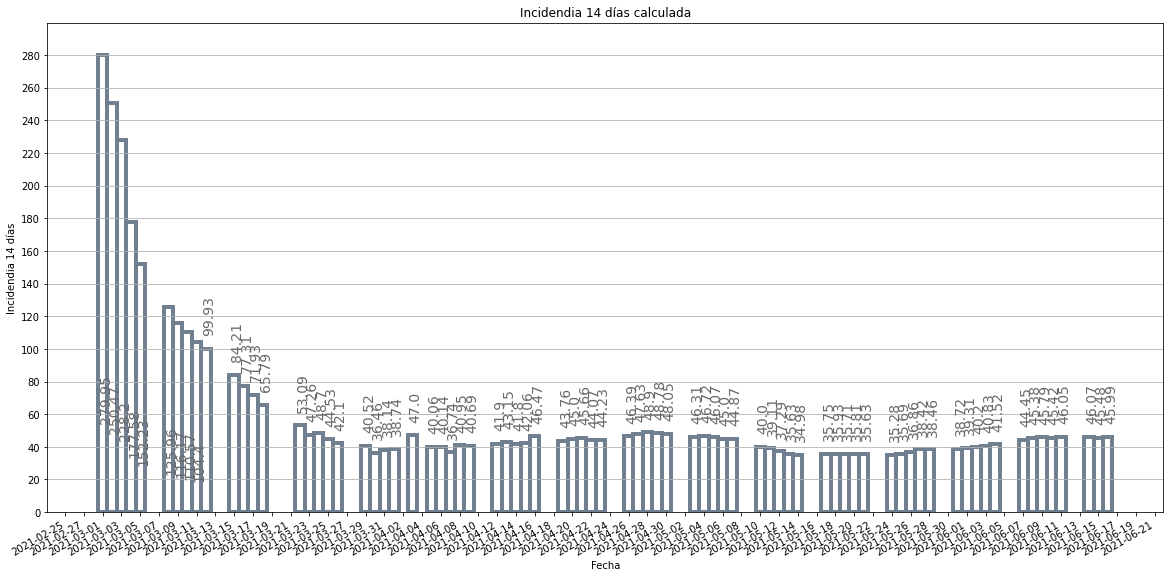

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(data_2021.index,data_2021["IA_14d_me"],width=1,fill=False,linewidth=4,ec="slategray")


ax.set_title('Incidendia 14 días calculada')
ax.set_ylabel('Incidendia 14 días')
ax.set_xlabel('Fecha')

# Ponemos etiquetas y configuramos los ejes
ax.set_ylim((0,300))
starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 20))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 100:
        ax.text(i.get_x()+.1, i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 100:
            ax.text(i.get_x()+.1, i.get_height()+10, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

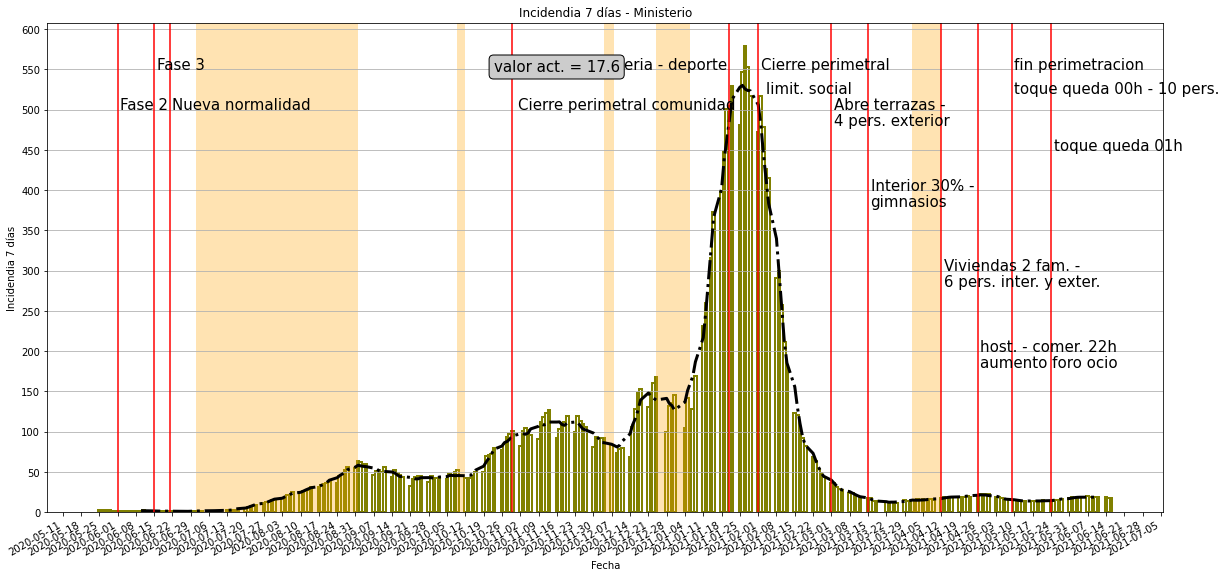

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data.index,data["inci_7"],width=1,fill=False,linewidth=2,ec="olive")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp2["inci_7"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linestyle="-.",linewidth=3)

# Dibujamos líneas verticales con cada cambio de las restricciones
ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
ax.text("2020-06-02",500,"Fase 2",fontsize=15)

ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
ax.text("2020-06-16",550,"Fase 3",fontsize=15)

ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
ax.text("2020-06-22",500,"Nueva normalidad",fontsize=15)

ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
ax.text("2020-11-01",500,"Cierre perimetral comunidad",fontsize=15)

ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
ax.text("2021-01-20",550,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
ax.text("2021-02-02",550,"Cierre perimetral",fontsize=15)
ax.text("2021-02-04",520,"limit. social",fontsize=15)

ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
ax.text("2021-03-02",500,"Abre terrazas -",fontsize=15)
ax.text("2021-03-02",480,"4 pers. exterior",fontsize=15)

ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
ax.text("2021-03-16",400,"Interior 30% -",fontsize=15)
ax.text("2021-03-16",380,"gimnasios",fontsize=15)

ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
ax.text("2021-04-13",300,"Viviendas 2 fam. -",fontsize=15)
ax.text("2021-04-13",280,"6 pers. inter. y exter.",fontsize=15)

ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
ax.text("2021-04-27",200,"host. - comer. 22h",fontsize=15)
ax.text("2021-04-27",180,"aumento foro ocio",fontsize=15)

ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
ax.text("2021-05-10",550,"fin perimetracion",fontsize=15)
ax.text("2021-05-10",520,"toque queda 00h - 10 pers.",fontsize=15)

ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
ax.text("2021-05-25",450,"toque queda 01h",fontsize=15)

# ax.axhline(y=data["inci_7"].iloc[-1],color="darkslategray",linestyle="--")

ax.annotate("valor act. = {:.5}".format(data["inci_7"].iloc[-1])
                  ,xy=(0.4, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 7 días - Ministerio')
ax.set_ylabel('Incidendia 7 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 50))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

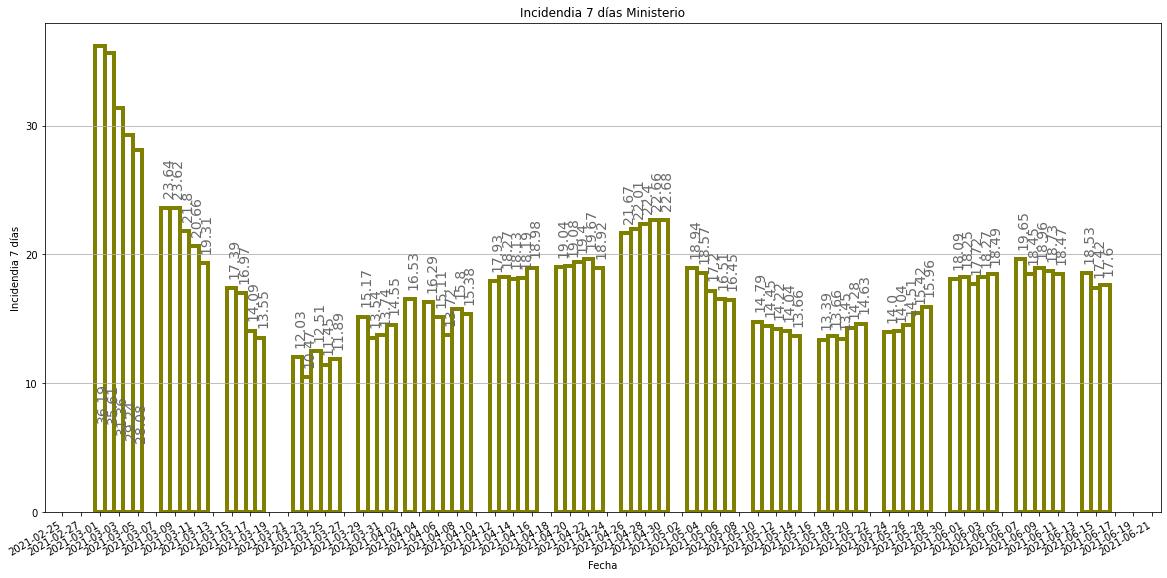

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data_2021.index,data_2021["inci_7"],width=1,fill=False,linewidth=4,ec="olive")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 7 días Ministerio')
ax.set_ylabel('Incidendia 7 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 10))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 25:
        ax.text(i.get_x()+.1, i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 25:
            ax.text(i.get_x()+.1, i.get_height()+1, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

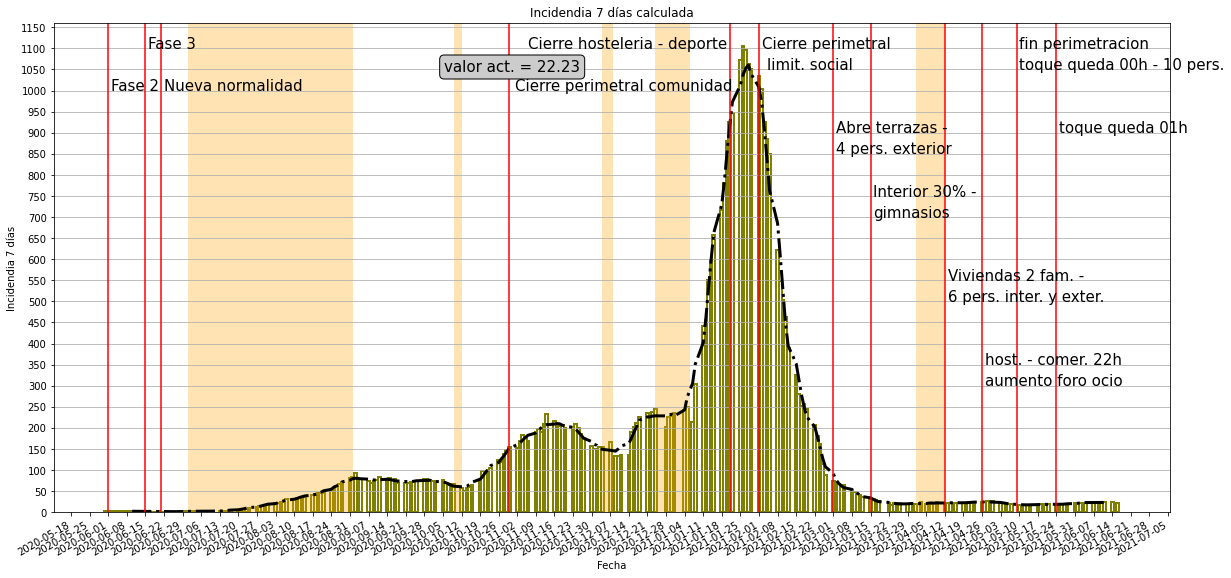

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data.index,data["IA_7d_me"],width=1,fill=False,linewidth=2,ec="olive")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp2["IA_7d_me"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linestyle="-.",linewidth=3)

# Dibujamos líneas verticales con cada cambio de las restricciones
ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
ax.text("2020-06-02",1000,"Fase 2",fontsize=15)

ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
ax.text("2020-06-16",1100,"Fase 3",fontsize=15)

ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
ax.text("2020-06-22",1000,"Nueva normalidad",fontsize=15)

ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
ax.text("2020-11-01",1000,"Cierre perimetral comunidad",fontsize=15)

ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
ax.text("2021-01-20",1100,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
ax.text("2021-02-02",1100,"Cierre perimetral",fontsize=15)
ax.text("2021-02-04",1050,"limit. social",fontsize=15)

ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
ax.text("2021-03-02",900,"Abre terrazas -",fontsize=15)
ax.text("2021-03-02",850,"4 pers. exterior",fontsize=15)

ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
ax.text("2021-03-16",750,"Interior 30% -",fontsize=15)
ax.text("2021-03-16",700,"gimnasios",fontsize=15)

ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
ax.text("2021-04-13",550,"Viviendas 2 fam. -",fontsize=15)
ax.text("2021-04-13",500,"6 pers. inter. y exter.",fontsize=15)

ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
ax.text("2021-04-27",350,"host. - comer. 22h",fontsize=15)
ax.text("2021-04-27",300,"aumento foro ocio",fontsize=15)

ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
ax.text("2021-05-10",1100,"fin perimetracion",fontsize=15)
ax.text("2021-05-10",1050,"toque queda 00h - 10 pers.",fontsize=15)

ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
ax.text("2021-05-25",900,"toque queda 01h",fontsize=15)

# ax.axhline(y=data["IA_7d_me"].iloc[-1],color="darkslategray",linestyle="--")

ax.annotate("valor act. = {:.5}".format(data["IA_7d_me"].iloc[-1])
                  ,xy=(0.35, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 7 días calculada')
ax.set_ylabel('Incidendia 7 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 50))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

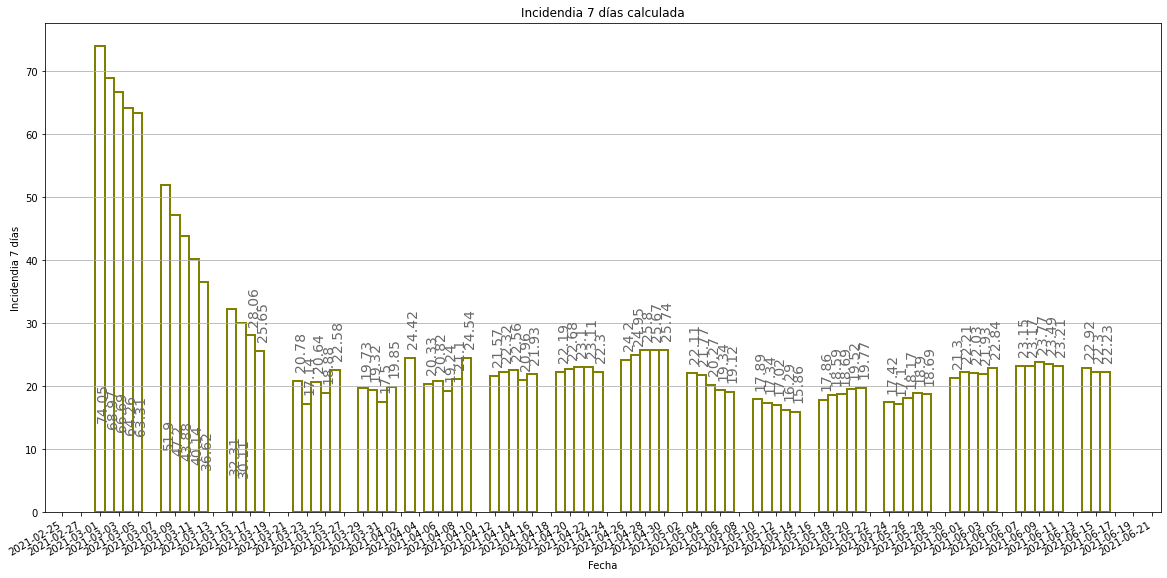

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data_2021.index,data_2021["IA_7d_me"],width=1,fill=False,linewidth=2,ec="olive")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Incidendia 7 días calculada')
ax.set_ylabel('Incidendia 7 días')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 10))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 30:
        ax.text(i.get_x()+.1, i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 30:
            ax.text(i.get_x()+.1, i.get_height()+2, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

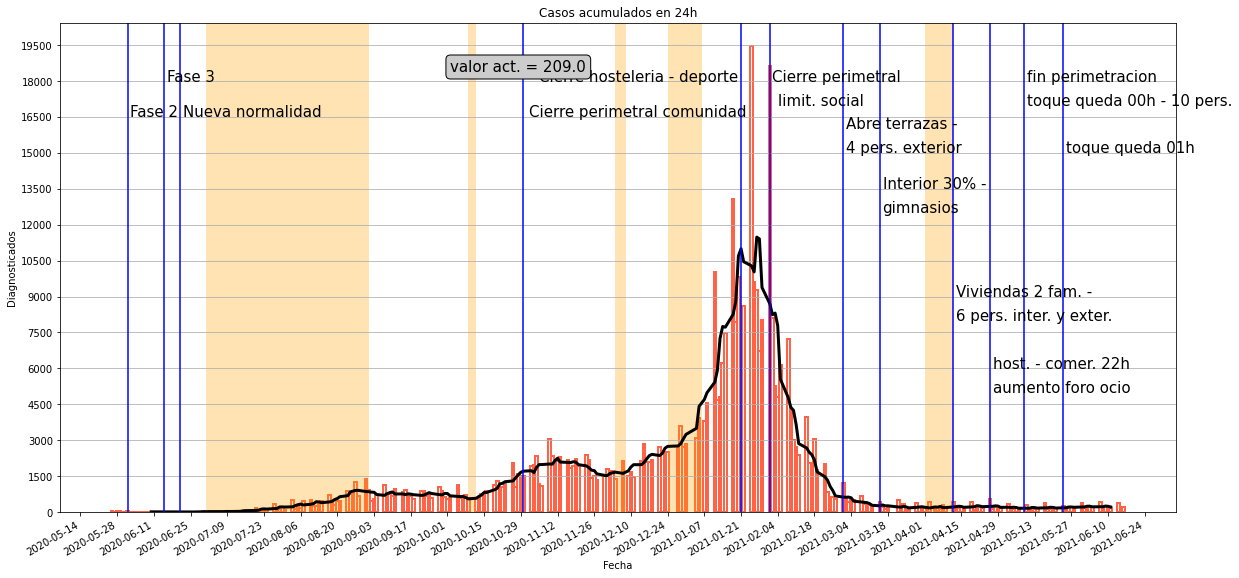

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data.index,data["casos_24h"],width=1,fill=False,linewidth=2,ec="tomato")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp2["casos_24h"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linewidth=3)

# Linea horizontal con el último valor calculado de la tendencia de los datos
# ax.axhline(y=decompose.trend.iloc[-4],color="dodgerblue",linestyle="--")

# Dibujamos líneas verticales con cada cambio de las restricciones
ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="blue")
ax.text("2020-06-02",16500,"Fase 2",fontsize=15)

ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="blue")
ax.text("2020-06-16",18000,"Fase 3",fontsize=15)

ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="blue")
ax.text("2020-06-22",16500,"Nueva normalidad",fontsize=15)

ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="blue")
ax.text("2020-11-01",16500,"Cierre perimetral comunidad",fontsize=15)

ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="blue")
ax.text("2021-01-20",18000,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="blue")
ax.text("2021-02-02",18000,"Cierre perimetral",fontsize=15)
ax.text("2021-02-04",17000,"limit. social",fontsize=15)

ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="blue")
ax.text("2021-03-02",16000,"Abre terrazas -",fontsize=15)
ax.text("2021-03-02",15000,"4 pers. exterior",fontsize=15)

ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="blue")
ax.text("2021-03-16",13500,"Interior 30% -",fontsize=15)
ax.text("2021-03-16",12500,"gimnasios",fontsize=15)

ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="blue")
ax.text("2021-04-13",9000,"Viviendas 2 fam. -",fontsize=15)
ax.text("2021-04-13",8000,"6 pers. inter. y exter.",fontsize=15)

ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="blue")
ax.text("2021-04-27",6000,"host. - comer. 22h",fontsize=15)
ax.text("2021-04-27",5000,"aumento foro ocio",fontsize=15)

ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="blue")
ax.text("2021-05-10",18000,"fin perimetracion",fontsize=15)
ax.text("2021-05-10",17000,"toque queda 00h - 10 pers.",fontsize=15)

ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="blue")
ax.text("2021-05-25",15000,"toque queda 01h",fontsize=15)

ax.annotate("valor act. = {:.5}".format(data["casos_24h"].iloc[-1])
                  ,xy=(0.35, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Casos acumulados en 24h')
ax.set_ylabel('Diagnosticados')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 1500))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))

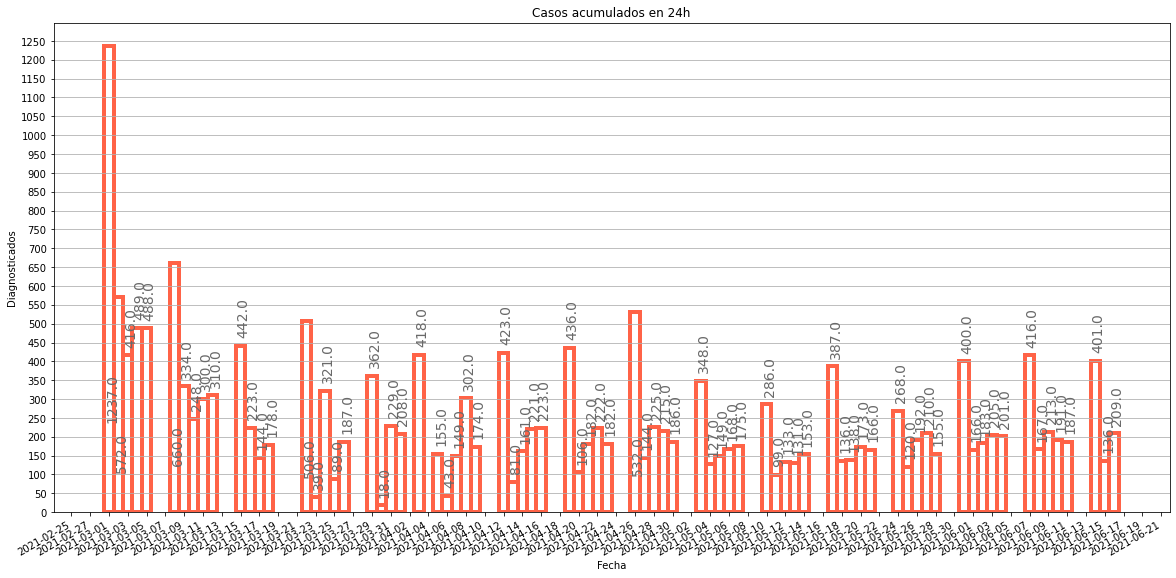

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data_2021.index,data_2021["casos_24h"],width=1,fill=False,linewidth=4,ec="tomato")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Casos acumulados en 24h')
ax.set_ylabel('Diagnosticados')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 50))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 500:
        ax.text(i.get_x()+.1, i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 500:
            ax.text(i.get_x()+.1, i.get_height()+30, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

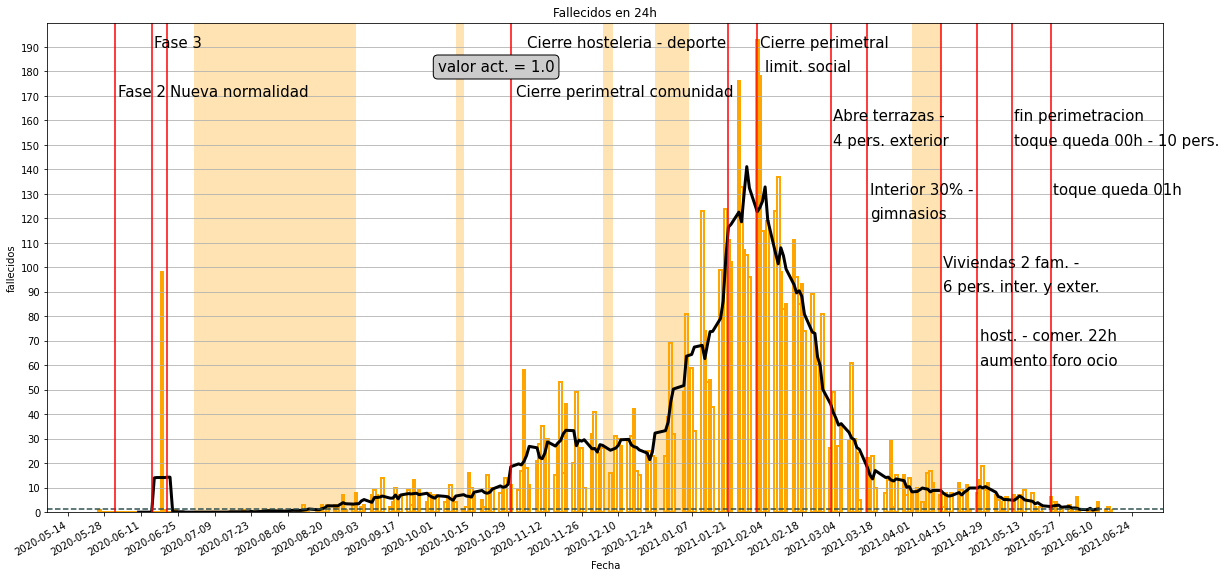

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data.index,data["fallecidos_24h"],width=1,fill=False,linewidth=2,ec="orange")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp2["fallecidos_24h"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linewidth=3)

# Linea horizontal con el último valor calculado de la tendencia de los datos
ax.axhline(y=decompose.trend.iloc[-4],color="darkslategray",linestyle="--")

# Dibujamos líneas verticales con cada cambio de las restricciones
ax.axvline(x="2020-06-01", ymin=0, ymax=1,color="red")
ax.text("2020-06-02",170,"Fase 2",fontsize=15)

ax.axvline(x="2020-06-15", ymin=0, ymax=1,color="red")
ax.text("2020-06-16",190,"Fase 3",fontsize=15)

ax.axvline(x="2020-06-21", ymin=0, ymax=1,color="red")
ax.text("2020-06-22",170,"Nueva normalidad",fontsize=15)

ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
ax.text("2020-11-01",170,"Cierre perimetral comunidad",fontsize=15)

ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
ax.text("2021-01-20",190,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
ax.text("2021-02-02",190,"Cierre perimetral",fontsize=15)
ax.text("2021-02-04",180,"limit. social",fontsize=15)

ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
ax.text("2021-03-02",160,"Abre terrazas -",fontsize=15)
ax.text("2021-03-02",150,"4 pers. exterior",fontsize=15)

ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
ax.text("2021-03-16",130,"Interior 30% -",fontsize=15)
ax.text("2021-03-16",120,"gimnasios",fontsize=15)

ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
ax.text("2021-04-13",100,"Viviendas 2 fam. -",fontsize=15)
ax.text("2021-04-13",90,"6 pers. inter. y exter.",fontsize=15)

ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
ax.text("2021-04-27",70,"host. - comer. 22h",fontsize=15)
ax.text("2021-04-27",60,"aumento foro ocio",fontsize=15)

ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
ax.text("2021-05-10",160,"fin perimetracion",fontsize=15)
ax.text("2021-05-10",150,"toque queda 00h - 10 pers.",fontsize=15)

ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
ax.text("2021-05-25",130,"toque queda 01h",fontsize=15)

ax.annotate("valor act. = {:.5}".format(data["fallecidos_24h"].iloc[-1])
                  ,xy=(0.35, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-07-01", "2020-09-01", facecolor='orange', alpha=0.3)
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Fallecidos en 24h')
ax.set_ylabel('fallecidos')
ax.set_xlabel('Fecha')

ax.set_ylim((0,200))
starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 10))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))

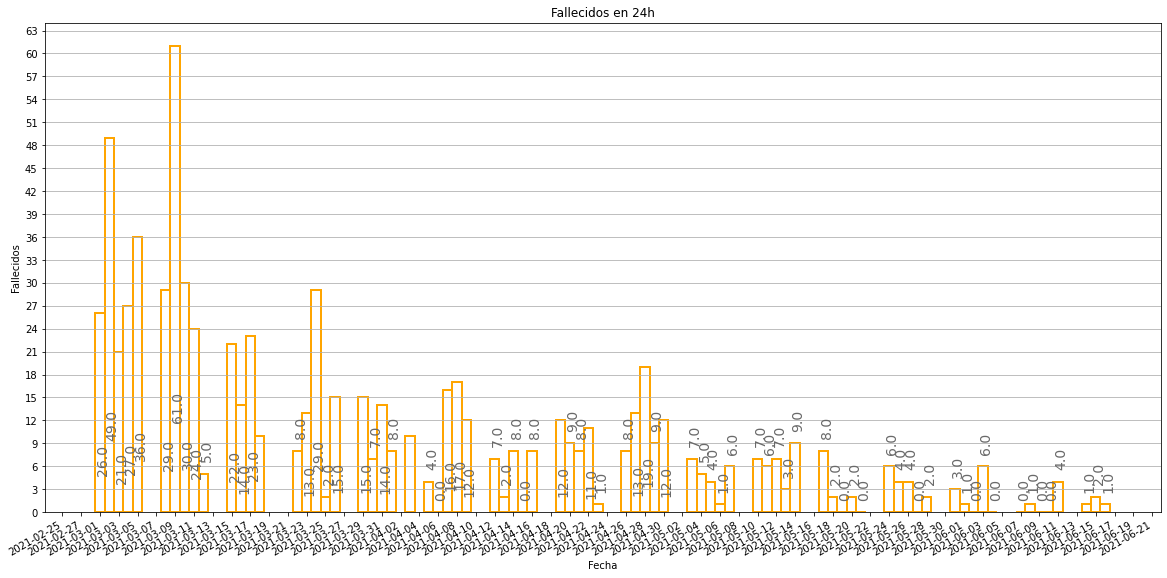

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data_2021.index,data_2021["fallecidos_24h"],width=1,fill=False,linewidth=2,ec="orange")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Fallecidos en 24h')
ax.set_ylabel('Fallecidos')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 3))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 10:
        ax.text(i.get_x()+.1, i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 10:
            ax.text(i.get_x()+.1, i.get_height()+2, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

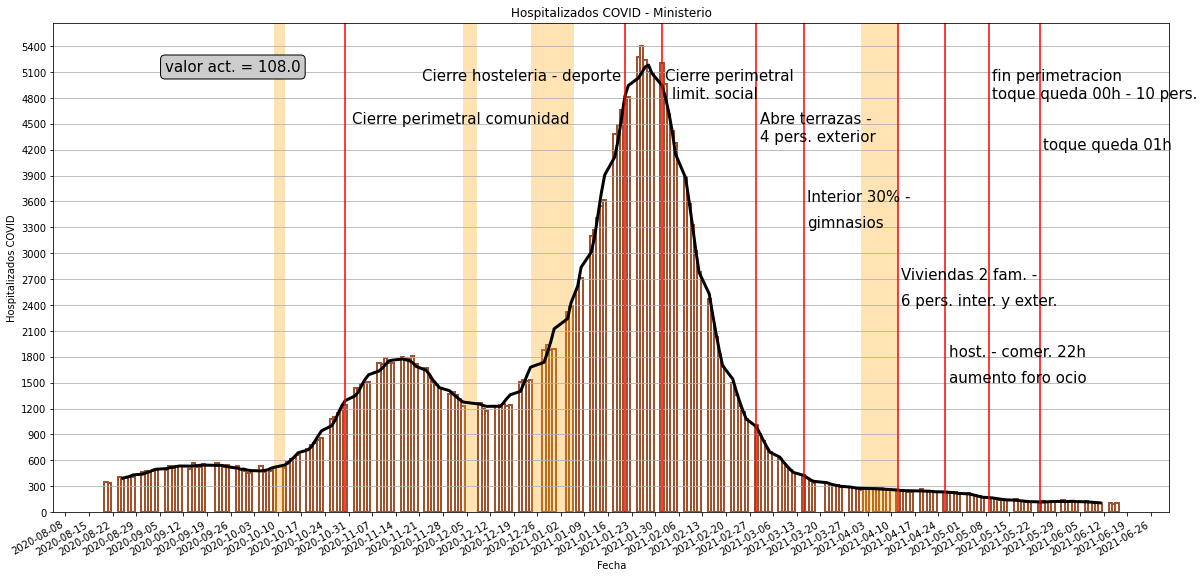

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
graf1=ax.bar(data_hosp.index,data_hosp["hospitalizados"],width=1,fill=False,linewidth=2,ec="sienna")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp3["hospitalizados"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linewidth=3)

# Dibujamos líneas verticales con cada cambio de las restricciones
ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
ax.text("2020-11-01",4500,"Cierre perimetral comunidad",fontsize=15)

ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
ax.text("2021-01-20",5000,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
ax.text("2021-02-02",5000,"Cierre perimetral",fontsize=15)
ax.text("2021-02-04",4800,"limit. social",fontsize=15)

ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
ax.text("2021-03-02",4500,"Abre terrazas -",fontsize=15)
ax.text("2021-03-02",4300,"4 pers. exterior",fontsize=15)

ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
ax.text("2021-03-16",3600,"Interior 30% -",fontsize=15)
ax.text("2021-03-16",3300,"gimnasios",fontsize=15)

ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
ax.text("2021-04-13",2700,"Viviendas 2 fam. -",fontsize=15)
ax.text("2021-04-13",2400,"6 pers. inter. y exter.",fontsize=15)

ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
ax.text("2021-04-27",1800,"host. - comer. 22h",fontsize=15)
ax.text("2021-04-27",1500,"aumento foro ocio",fontsize=15)

ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
ax.text("2021-05-10",5000,"fin perimetracion",fontsize=15)
ax.text("2021-05-10",4800,"toque queda 00h - 10 pers.",fontsize=15)

ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
ax.text("2021-05-25",4200,"toque queda 01h",fontsize=15)

# ax.axhline(y=data["hospitalizados"].iloc[-1],color="darkslategray",linestyle="--")

ax.annotate("valor act. = {:.5}".format(data["hospitalizados"].iloc[-1])
                  ,xy=(0.1, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Hospitalizados COVID - Ministerio')
ax.set_ylabel('Hospitalizados COVID')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 300))
ax.yaxis.grid()
fig.autofmt_xdate()

# Creamos un segundo eje para el porcentaje de ingresados
# temp=data_hosp.copy()
# temp=temp["por_hosp"].dropna(how='any',axis=0)

# ax2=ax.twinx() 
# ax2.plot(temp.index,temp,color="grey")
# ax2.set_ylabel('% pacientes Hospitalizados')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

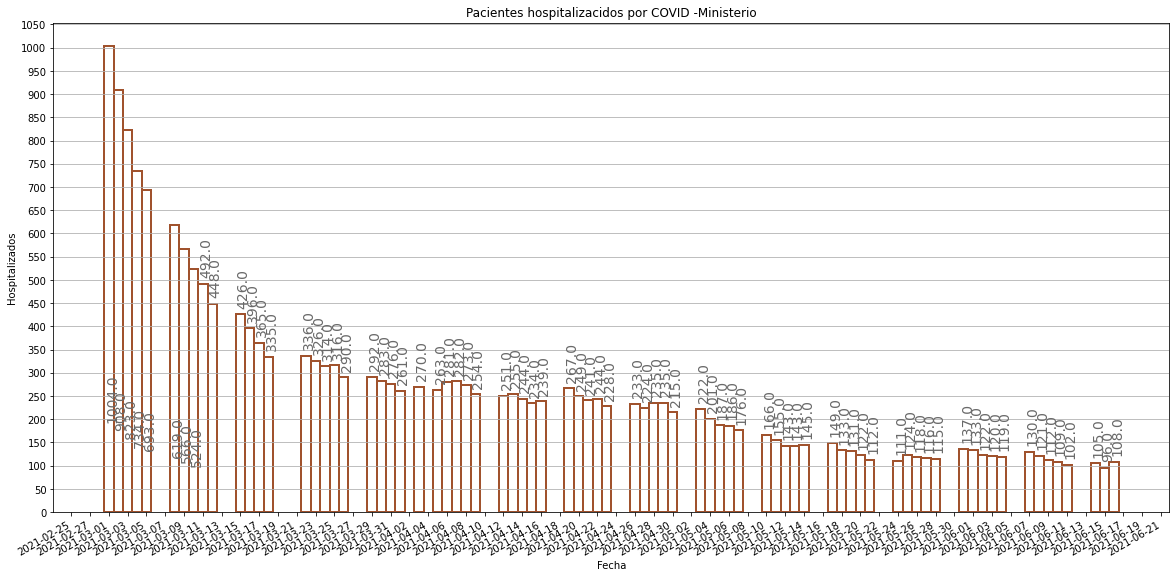

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data_2021.index,data_2021["hospitalizados"],width=1,fill=False,linewidth=2,ec="sienna")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Pacientes hospitalizacidos por COVID -Ministerio')
ax.set_ylabel('Hospitalizados')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 50))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 500:
        ax.text(i.get_x()+.1, i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 500:
            ax.text(i.get_x()+.1, i.get_height()+20, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)

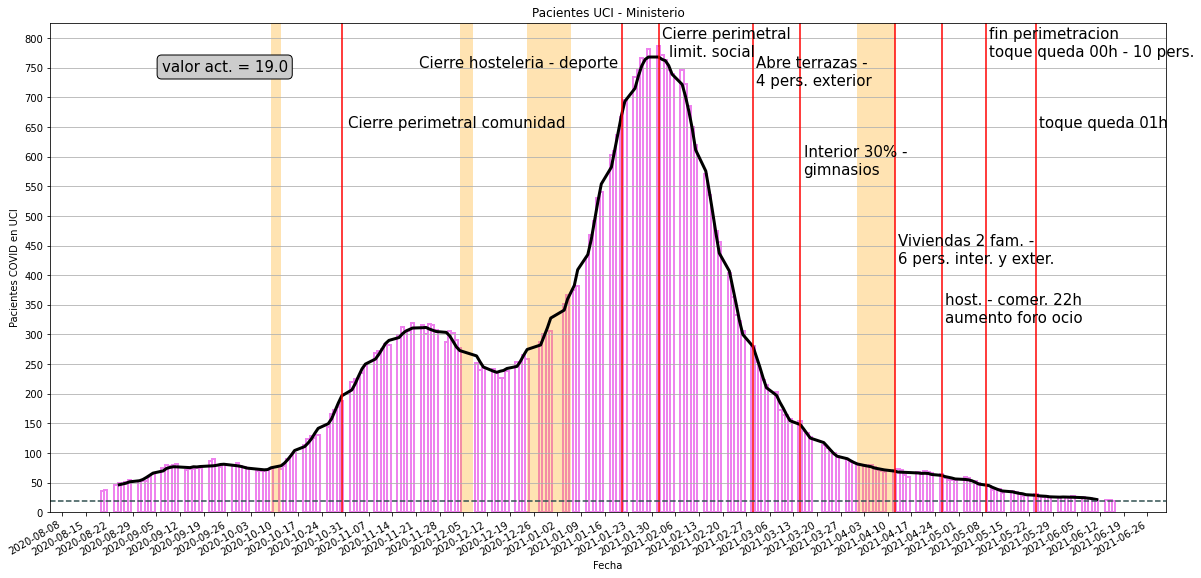

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
graf1=ax.bar(data_hosp.index,data_hosp["UCI"],width=1,fill=False,linewidth=2,ec="violet")

# Usamos una descomposición estacional usando promedios móviles para estimar la tendencia de los datos 
decompose = seasonal_decompose(temp3["UCI"],period=7)
# Representamos el resultado sobre los datos
ax.plot(decompose.trend.index, decompose.trend, c='black',linewidth=3)

# Dibujamos líneas verticales con cada cambio de las restricciones
ax.axvline(x="2020-10-30", ymin=0, ymax=1,color="red")
ax.text("2020-11-01",650,"Cierre perimetral comunidad",fontsize=15)

ax.axvline(x="2021-01-21", ymin=0, ymax=1,color="red")
ax.text("2021-01-20",750,"Cierre hosteleria - deporte",horizontalalignment="right",fontsize=15)

ax.axvline(x="2021-02-01", ymin=0, ymax=1,color="red")
ax.text("2021-02-02",800,"Cierre perimetral",fontsize=15)
ax.text("2021-02-04",770,"limit. social",fontsize=15)

ax.axvline(x="2021-03-01", ymin=0, ymax=1,color="red")
ax.text("2021-03-02",750,"Abre terrazas -",fontsize=15)
ax.text("2021-03-02",720,"4 pers. exterior",fontsize=15)

ax.axvline(x="2021-03-15", ymin=0, ymax=1,color="red")
ax.text("2021-03-16",600,"Interior 30% -",fontsize=15)
ax.text("2021-03-16",570,"gimnasios",fontsize=15)

ax.axvline(x="2021-04-12", ymin=0, ymax=1,color="red")
ax.text("2021-04-13",450,"Viviendas 2 fam. -",fontsize=15)
ax.text("2021-04-13",420,"6 pers. inter. y exter.",fontsize=15)

ax.axvline(x="2021-04-26", ymin=0, ymax=1,color="red")
ax.text("2021-04-27",350,"host. - comer. 22h",fontsize=15)
ax.text("2021-04-27",320,"aumento foro ocio",fontsize=15)

ax.axvline(x="2021-05-09", ymin=0, ymax=1,color="red")
ax.text("2021-05-10",800,"fin perimetracion",fontsize=15)
ax.text("2021-05-10",770,"toque queda 00h - 10 pers.",fontsize=15)

ax.axvline(x="2021-05-24", ymin=0, ymax=1,color="red")
ax.text("2021-05-25",650,"toque queda 01h",fontsize=15)

ax.axhline(y=data["UCI"].iloc[-1],color="darkslategray",linestyle="--")

ax.annotate("valor act. = {:.5}".format(data["UCI"].iloc[-1])
                  ,xy=(0.1, 0.9), xycoords='axes fraction',fontsize=15,color="black",bbox=bbox_args)

# Dibujamos sombreado los periodos de vacaciones
plt.axvspan("2020-10-09", "2020-10-12", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-04", "2020-12-08", facecolor='orange', alpha=0.3)
plt.axvspan("2020-12-24", "2021-01-06", facecolor='orange', alpha=0.3)
plt.axvspan("2021-04-01", "2021-04-12", facecolor='orange', alpha=0.3)

# Ponemos etiquetas y configuramos los ejes
ax.set_title('Pacientes UCI - Ministerio')
ax.set_ylabel('Pacientes COVID en UCI')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 50))
ax.yaxis.grid()
fig.autofmt_xdate()

# temp=data_hosp.copy()
# temp=temp["por_UCI"].dropna(how='any',axis=0)


# ax2=ax.twinx() 
# ax2.plot(temp.index,temp,color="grey")
# ax2.set_ylabel('% pacientes UCI')
# # ax2.yaxis.grid()

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

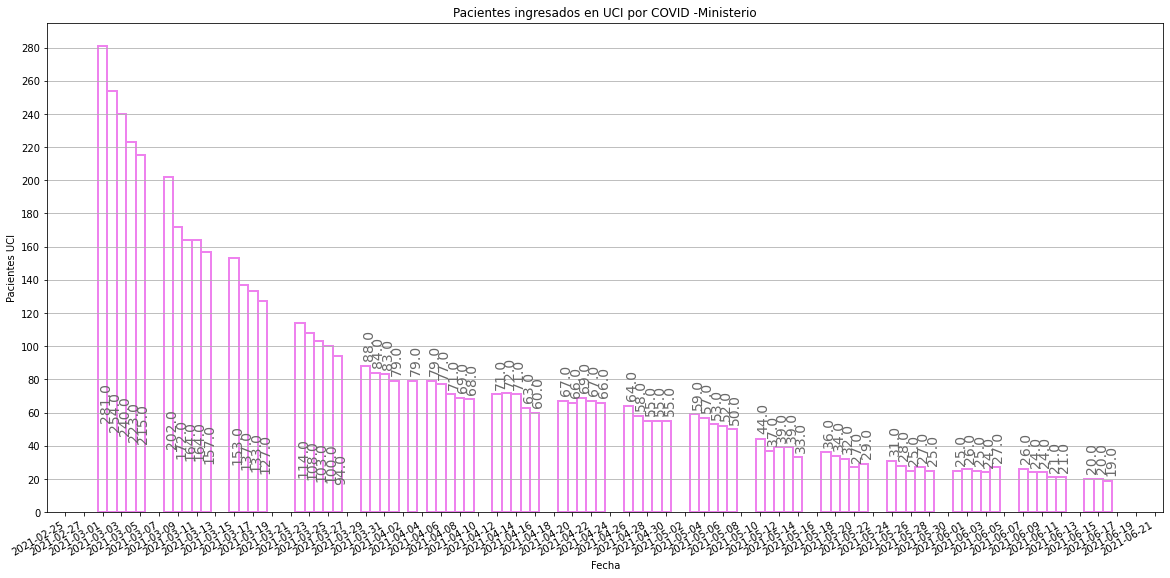

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
graf2=ax.bar(data_2021.index,data_2021["UCI"],width=1,fill=False,linewidth=2,ec="violet")


# Ponemos etiquetas y configuramos los ejes
ax.set_title('Pacientes ingresados en UCI por COVID -Ministerio')
ax.set_ylabel('Pacientes UCI')
ax.set_xlabel('Fecha')

starty, endy = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(starty, endy, 20))
ax.yaxis.grid()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Indicamos dentro de cada barra el valor de la indicencia ese días
for i in ax.patches:
    if (not np.isnan(i.get_height())) and i.get_height() > 90:
        ax.text(i.get_x()+.1, i.get_height()-0.8*i.get_height(), \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)
    if (not np.isnan(i.get_height())) and i.get_height() < 90:
            ax.text(i.get_x()+.1, i.get_height()+5, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                rotation=90)